<a href="https://colab.research.google.com/github/HermesMG/HermesMG/blob/main/hmg_C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [33]:
#!pip install tensorflow==2.5.0

In [34]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [35]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [36]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 65.8MB/s]


In [37]:
import pandas as pd
sunspot_df = pd.read_csv("/content/Sunspots.csv")

In [38]:
sunspot_df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [39]:
sunspot_df.columns

Index(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [40]:
sunspot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3235 non-null   int64  
 1   Date                               3235 non-null   object 
 2   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 75.9+ KB


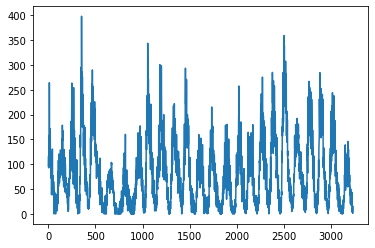

In [41]:
sunspot_df.loc[:,'Monthly Mean Total Sunspot Number'].plot();

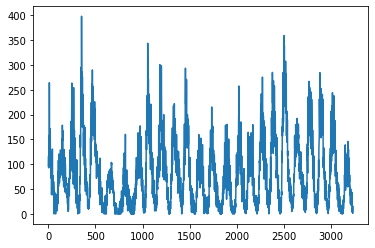

In [42]:
sunspot_df['Monthly Mean Total Sunspot Number'].plot();

In [43]:
import csv
time_step = []
sunspots = []
with open('./Sunspots.csv') as csvfile:
 
      reader = csv.reader(csvfile, delimiter=',')
      next(reader)
      i = 0
      for row in reader:
        sunspots.append(float(row[2]))
        print ("float(row[2]):", float(row[2]))
        time_step.append(int(row[0]))
        print ("int(row[0]):", int(row[0]))
        i+=1
        if i == 2:
          break

float(row[2]): 96.7
int(row[0]): 0
float(row[2]): 104.3
int(row[0]): 1


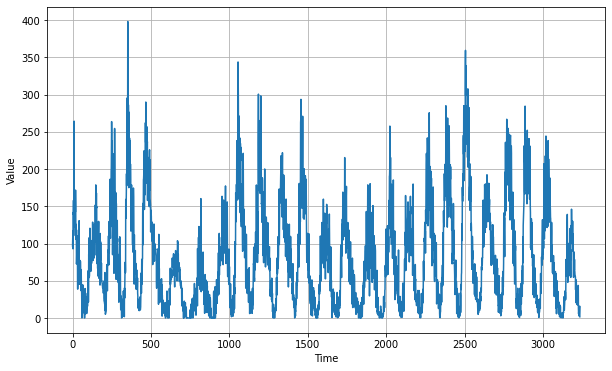

In [44]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

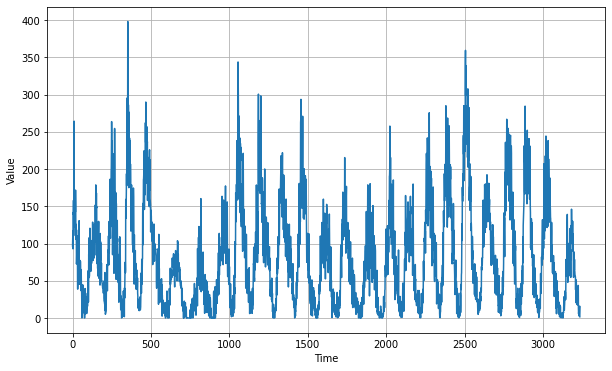

In [45]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [46]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [48]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 5s 38ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 52ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 74ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 51ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 47ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 46ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 56ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [===============

(1e-08, 0.0001, 0.0, 60.0)

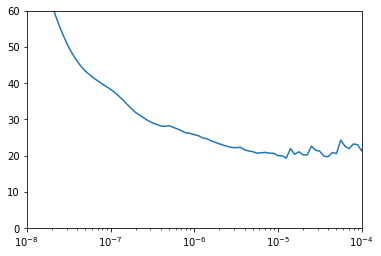

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [51]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
30/30 [==============================] - 4s 18ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 22.0771 - mae: 22.5708
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 20.4753 - mae: 20.9683
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 19.7862 - mae: 20.2786
Epoch 6/100
30/30 [==============================] - 1s 18ms/step - loss: 19.2803 - mae: 19.7725
Epoch 7/100
30/30 [==============================] - 1s 18ms/step - loss: 18.7042 - mae: 19.1963
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 18.1199 - mae: 18.6115
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 18.1432 - mae: 18.6348
Epoch 10/100
30/30 [==============================] - 1s 19ms/step - loss: 17.9817 - mae: 18.4728
Epoch 11/100
30/30 [=========

In [52]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

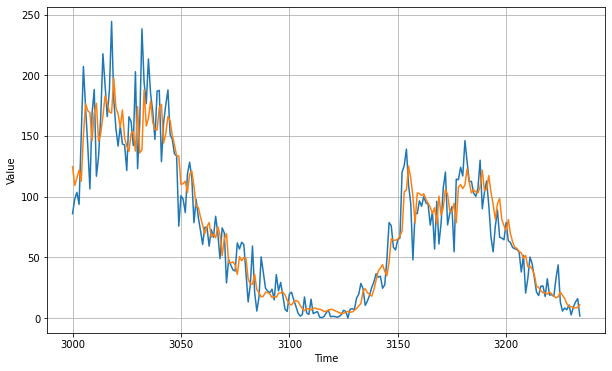

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [54]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
maes={}
maes["moroney"]= mae
mae
print ("Era con 500 epochs:",15.853092, "ahora con 100 es:",mae)

Era con 500 epochs: 15.853092 ahora con 100 es: 14.098904


<Figure size 432x288 with 0 Axes>

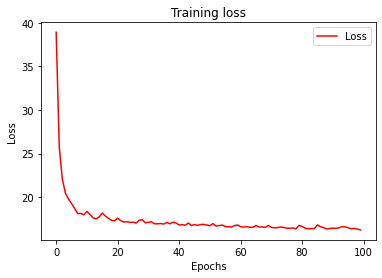

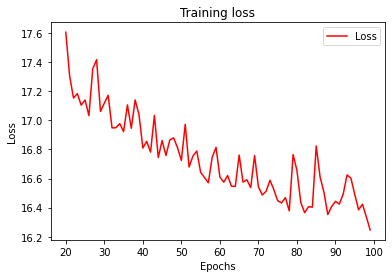

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[20:]
zoomed_epochs = range(20,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [77]:
#print(rnn_forecast)

# Pruebo con callbacks

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
early_stopping = EarlyStopping(patience=30, monitor='mae')
reduce_lr = ReduceLROnPlateau(monitor='mae', min_lr=1e-8,
patience=10, mode='min',
verbose=1)
model_checkpoint = ModelCheckpoint(monitor='mae',
filepath='./best_model.h5',
save_best_only=True)
callbacks = [early_stopping, reduce_lr,  model_checkpoint]

Epoch 1/500
30/30 [==============================] - 4s 18ms/step - loss: 47.7308 - mae: 48.2281 - lr: 1.0000e-04
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 44.2541 - mae: 44.7514 - lr: 1.0000e-04
Epoch 3/500
30/30 [==============================] - 1s 17ms/step - loss: 48.8024 - mae: 49.2998 - lr: 1.0000e-04
Epoch 4/500
30/30 [==============================] - 1s 18ms/step - loss: 45.7215 - mae: 46.2184 - lr: 1.0000e-04
Epoch 5/500
30/30 [==============================] - 1s 18ms/step - loss: 44.3653 - mae: 44.8624 - lr: 1.0000e-04
Epoch 6/500
30/30 [==============================] - 1s 19ms/step - loss: 38.6817 - mae: 39.1783 - lr: 1.0000e-04
Epoch 7/500
30/30 [==============================] - 1s 18ms/step - loss: 40.1793 - mae: 40.6757 - lr: 1.0000e-04
Epoch 8/500
30/30 [==============================] - 1s 19ms/step - loss: 37.0692 - mae: 37.5658 - lr: 1.0000e-04
Epoch 9/500
30/30 [==============================] - 1s 19ms/step - loss: 33.3050 - mae:

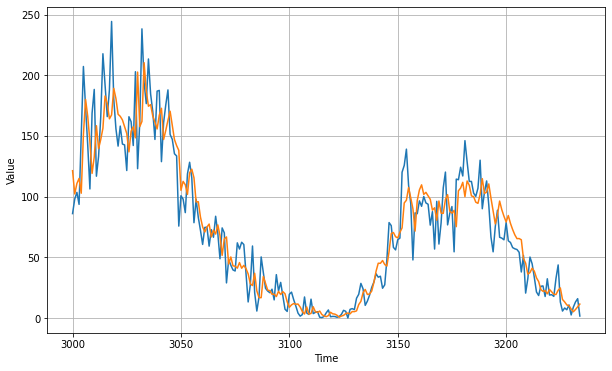

In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[callbacks])
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print (f"mae:{tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}")

In [59]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

maes["callback"]= mae

In [60]:
maes

{'callback': 14.548768, 'moroney': 14.098904}

mae:14.536600112915039


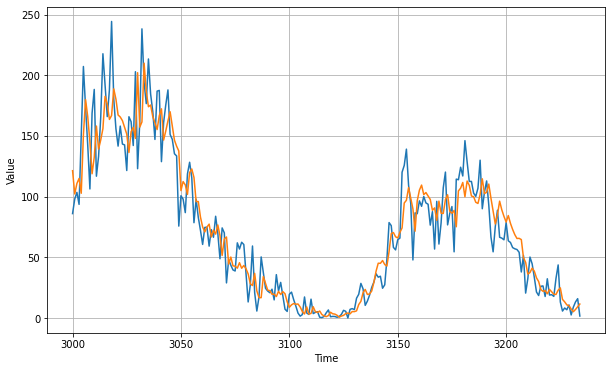

In [61]:
model = tf.keras.models.load_model("best_model.h5")
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print (f"mae:{tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}")

In [62]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

maes["best_model"]= mae
mae

14.5366

In [63]:
print (f"maes:{maes}")
"""maes anterior: {'best_model': 14.319451, 'callback': 14.317717, 'moroney': 14.147696}"""


maes:{'moroney': 14.098904, 'callback': 14.548768, 'best_model': 14.5366}


"maes anterior: {'best_model': 14.319451, 'callback': 14.317717, 'moroney': 14.147696}"

# Pruebo con vanilla nn

Epoch 1/500
30/30 [==============================] - 2s 19ms/step - loss: 3740.4426 - mae: 3740.9404 - lr: 1.0000e-04
Epoch 2/500
30/30 [==============================] - 1s 14ms/step - loss: 54.4488 - mae: 54.9472 - lr: 1.0000e-04
Epoch 3/500
30/30 [==============================] - 1s 14ms/step - loss: 54.4574 - mae: 54.9556 - lr: 1.0000e-04
Epoch 4/500
30/30 [==============================] - 1s 14ms/step - loss: 54.0521 - mae: 54.5505 - lr: 1.0000e-04
Epoch 5/500
30/30 [==============================] - 1s 14ms/step - loss: 54.3599 - mae: 54.8580 - lr: 1.0000e-04
Epoch 6/500
30/30 [==============================] - 1s 14ms/step - loss: 54.2467 - mae: 54.7451 - lr: 1.0000e-04
Epoch 7/500
30/30 [==============================] - 1s 15ms/step - loss: 54.3527 - mae: 54.8510 - lr: 1.0000e-04
Epoch 8/500
30/30 [==============================] - 1s 14ms/step - loss: 54.2974 - mae: 54.7958 - lr: 1.0000e-04
Epoch 9/500
30/30 [==============================] - 1s 14ms/step - loss: 54.3885 - 

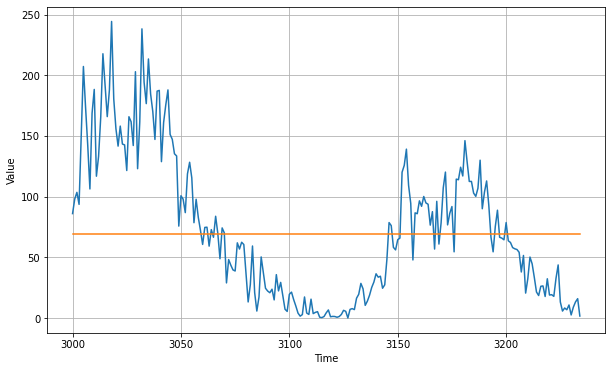

In [76]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500, callbacks=[callbacks])
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
print (f"mae:{tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()}")
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
maes["vanilla"]=mae